In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load the data
data = pd.read_csv('student_performance_analysis.csv')

# Display basic information about the data
data.head()

,student_id,gender,hours_studied,attendance_percent,assignments_completed,test_score
0,1,Female,6.3,61,6,50.9
1,2,Male,7.6,62,7,51.8
2,3,Female,8.9,63,8,52.7
3,4,Male,10.2,64,9,53.6
4,5,Female,11.5,65,10,54.5


In [ ]:
le = LabelEncoder()
data['gender'] = le.fit_transform(data['gender'])
data['performance'] = (data['test_score'] >= 70).astype(int)

In [5]:
# Features and target variable
features = ['gender', 'hours_studied', 'attendance_percent', 'assignments_completed']
X = data[features]
y = data['performance']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Positive class (Pass) in training: {y_train.sum()} ({y_train.sum()/len(y_train)*100:.1f}%)")
print(f"Positive class (Pass) in test: {y_test.sum()} ({y_test.sum()/len(y_test)*100:.1f}%)")


Training set size: 35 samples
Test set size: 15 samples
Positive class (Pass) in training: 19 (54.3%)
Positive class (Pass) in test: 8 (53.3%)


In [6]:
# Train Random Forest model

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

In [7]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display results
print("\nMODEL PERFORMANCE METRICS:")
print("=" * 50)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print("\nCONFUSION MATRIX:")
print(conf_matrix)

print("\n" + "=" * 50)
print("DETAILED CLASSIFICATION REPORT:")
print("=" * 50)
print(classification_report(y_test, y_pred, target_names=['Fail (0)', 'Pass (1)']))


MODEL PERFORMANCE METRICS:
Accuracy: 0.7333
Precision: 0.8333
Recall: 0.6250
F1-Score: 0.7143

CONFUSION MATRIX:
[[6 1]
 [3 5]]

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    Fail (0)       0.67      0.86      0.75         7
    Pass (1)       0.83      0.62      0.71         8

    accuracy                           0.73        15
   macro avg       0.75      0.74      0.73        15
weighted avg       0.76      0.73      0.73        15



In [8]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance)

                 Feature  Importance
2     attendance_percent    0.774799
1          hours_studied    0.105382
3  assignments_completed    0.090115
0                 gender    0.029705


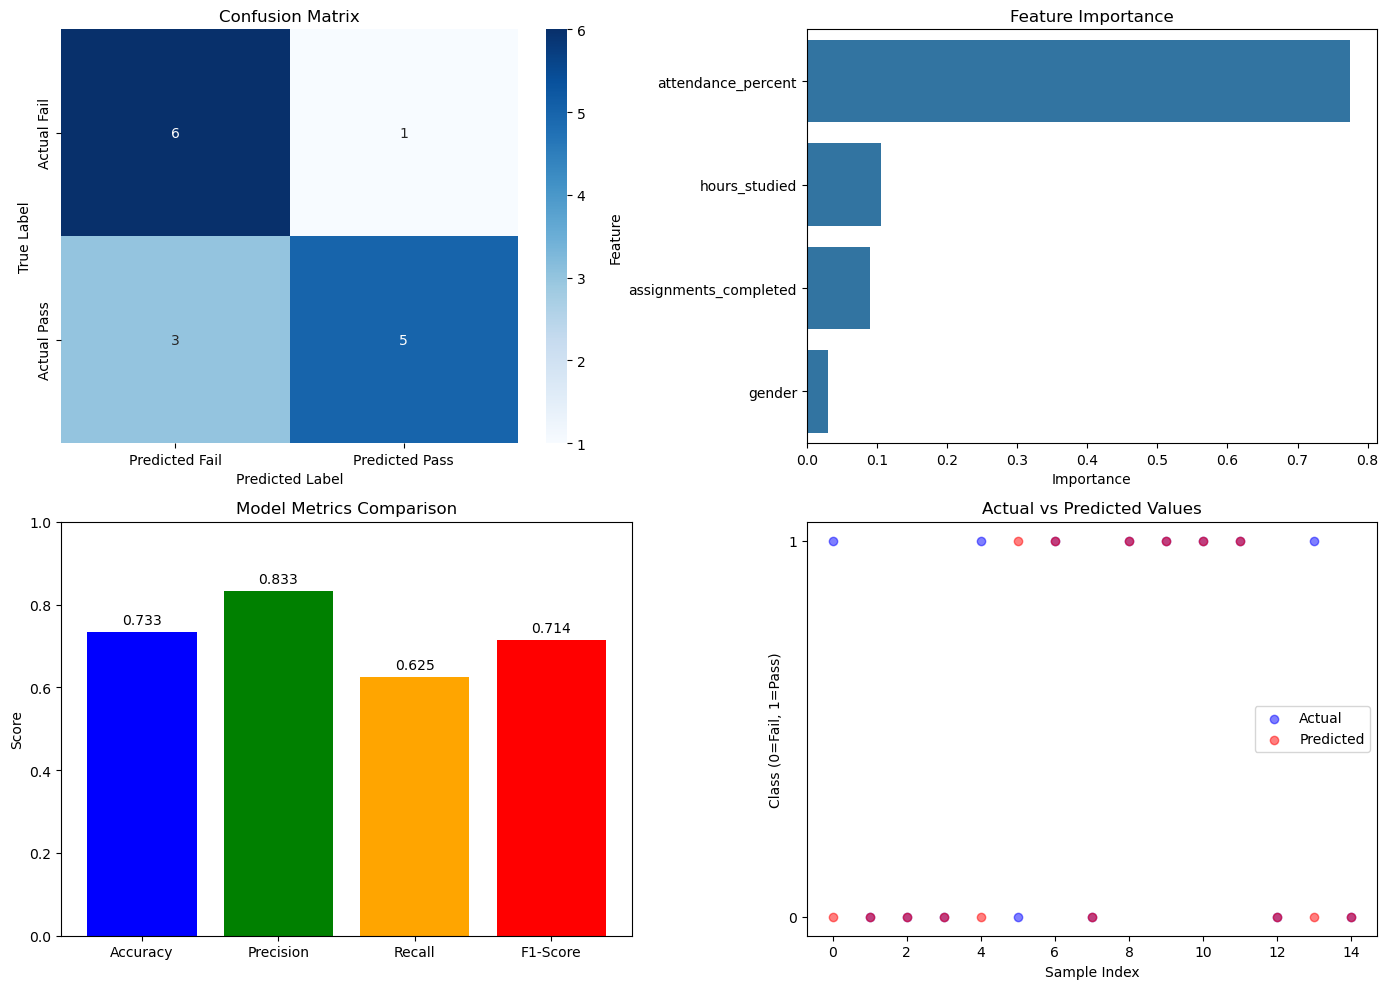

In [9]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Confusion Matrix Heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Fail', 'Predicted Pass'],
            yticklabels=['Actual Fail', 'Actual Pass'],
            ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')
# 2. Feature Importance Bar Plot
sns.barplot(x='Importance', y='Feature', data=feature_importance, ax=axes[0, 1])
axes[0, 1].set_title('Feature Importance')
axes[0, 1].set_xlabel('Importance')

# 3. Metrics Comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]
colors = ['blue', 'green', 'orange', 'red']
axes[1, 0].bar(metrics, values, color=colors)
axes[1, 0].set_title('Model Metrics Comparison')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_ylim([0, 1])
for i, v in enumerate(values):
    axes[1, 0].text(i, v + 0.02, f'{v:.3f}', ha='center')

# 4. Actual vs Predicted
axes[1, 1].scatter(range(len(y_test)), y_test, alpha=0.5, label='Actual', color='blue')
axes[1, 1].scatter(range(len(y_test)), y_pred, alpha=0.5, label='Predicted', color='red')
axes[1, 1].set_title('Actual vs Predicted Values')
axes[1, 1].set_xlabel('Sample Index')
axes[1, 1].set_ylabel('Class (0=Fail, 1=Pass)')
axes[1, 1].legend()
axes[1, 1].set_yticks([0, 1])

plt.tight_layout()
plt.show()



In [10]:
# Print detailed confusion matrix analysis
print("\n" + "=" * 50)
print("CONFUSION MATRIX ANALYSIS:")
print("=" * 50)
tn, fp, fn, tp = conf_matrix.ravel()
print(f"True Negatives (TN): {tn} - Correctly predicted Fail")
print(f"False Positives (FP): {fp} - Incorrectly predicted Pass (Type I Error)")
print(f"False Negatives (FN): {fn} - Incorrectly predicted Fail (Type II Error)")
print(f"True Positives (TP): {tp} - Correctly predicted Pass")
print(f"\nTotal Samples: {len(y_test)}")
print(f"Correct Predictions: {tn + tp} ({((tn + tp)/len(y_test))*100:.1f}%)")
print(f"Incorrect Predictions: {fp + fn} ({((fp + fn)/len(y_test))*100:.1f}%)")


CONFUSION MATRIX ANALYSIS:
True Negatives (TN): 6 - Correctly predicted Fail
False Positives (FP): 1 - Incorrectly predicted Pass (Type I Error)
False Negatives (FN): 3 - Incorrectly predicted Fail (Type II Error)
True Positives (TP): 5 - Correctly predicted Pass

Total Samples: 15
Correct Predictions: 11 (73.3%)
Incorrect Predictions: 4 (26.7%)


In [11]:
# Additional metrics derived from confusion matrix
print("\n" + "=" * 50)
print("DERIVED METRICS FROM CONFUSION MATRIX:")
print("=" * 50)
print(f"Error Rate: {(fp + fn)/(tp + tn + fp + fn):.4f}")
print(f"False Positive Rate: {fp/(fp + tn):.4f}")
print(f"False Negative Rate: {fn/(fn + tp):.4f}")
print(f"True Negative Rate (Specificity): {tn/(tn + fp):.4f}")
print(f"True Positive Rate (Recall/Sensitivity): {tp/(tp + fn):.4f}")


DERIVED METRICS FROM CONFUSION MATRIX:
Error Rate: 0.2667
False Positive Rate: 0.1429
False Negative Rate: 0.3750
True Negative Rate (Specificity): 0.8571
True Positive Rate (Recall/Sensitivity): 0.6250


In [12]:
# Example predictions
print("Test Set Sample Predictions:")
sample_indices = np.random.choice(len(X_test), 5, replace=False)
for idx in sample_indices:
    actual = y_test.iloc[idx]
    predicted = y_pred[idx]
    proba = y_pred_proba[idx]
    student_data = X_test.iloc[idx]
    
    print(f"\nStudent Data: Gender={student_data['gender']}, "
          f"Hours Studied={student_data['hours_studied']:.1f}, "
          f"Attendance={student_data['attendance_percent']}%, "
          f"Assignments={student_data['assignments_completed']}")
    print(f"Predicted: {'Pass' if predicted == 1 else 'Fail'} (Probability: {proba:.3f})")
    print(f"Actual: {'Pass' if actual == 1 else 'Fail'}")
    print(f"Result: {'Correct' if predicted == actual else 'Incorrect'}")


Test Set Sample Predictions:

Student Data: Gender=1.0, Hours Studied=15.4, Attendance=98.0%, Assignments=13.0
Predicted: Pass (Probability: 0.900)
Actual: Pass
Result: Correct

Student Data: Gender=1.0, Hours Studied=5.0, Attendance=70.0%, Assignments=5.0
Predicted: Fail (Probability: 0.160)
Actual: Fail
Result: Correct

Student Data: Gender=0.0, Hours Studied=11.5, Attendance=75.0%, Assignments=10.0
Predicted: Fail (Probability: 0.115)
Actual: Fail
Result: Correct

Student Data: Gender=1.0, Hours Studied=7.6, Attendance=92.0%, Assignments=7.0
Predicted: Pass (Probability: 0.916)
Actual: Pass
Result: Correct

Student Data: Gender=1.0, Hours Studied=10.2, Attendance=64.0%, Assignments=9.0
Predicted: Fail (Probability: 0.160)
Actual: Pass
Result: Incorrect


In [17]:
import joblib
joblib.dump(rf_model, "model.pkl")


['model.pkl']

In [18]:
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']